<a href="https://colab.research.google.com/github/AlexMan2000/DS-GA-Capstone/blob/master/Capstone_Code_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Prepare Environments

In [ ]:
!pip install -q -U google-generativeai
!pip install datasets
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install upgrade transformers

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


# 1 Multiple Image Inference

## 1.1 Load Dataset

In [ ]:
from datasets import load_from_disk
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/Downloaded_Datasets/spatial_understanding"
# dataset = load_from_disk("/content/drive/MyDrive/Downloaded_Datasets/nyu_depth_v2_train")

Mounted at /content/drive


## 1.2 Show Sample data

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_set = dataset
idx = np.random.choice(len(train_set), 9).tolist()[0]
image, depth = train_set[idx]["image"], train_set[idx]["depth_map"]

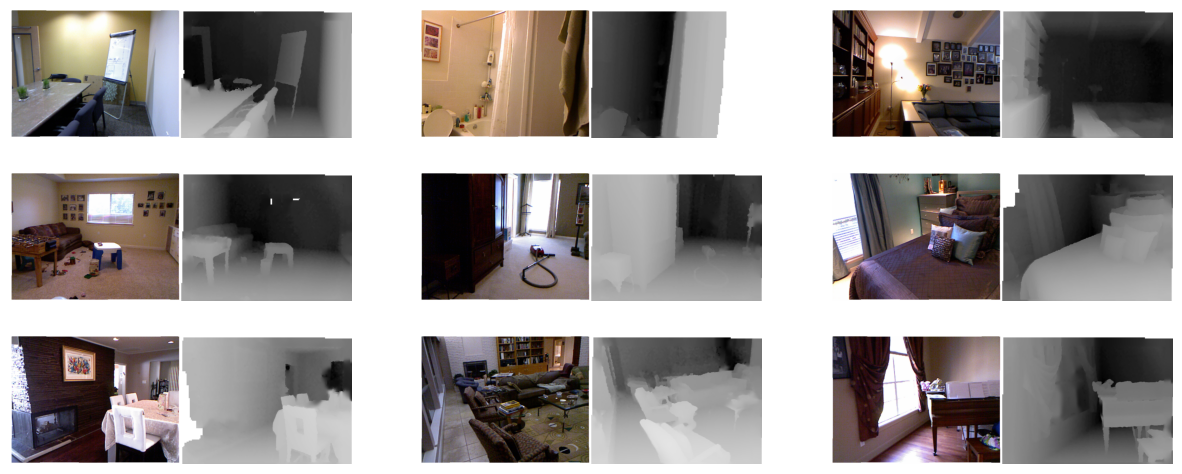

In [ ]:
def colored_depthmap(depth, d_min=None, d_max=None, mode="gray"):

    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)

    if mode == "gray":
      depth_inverted = 1 - depth_relative
      depth_gray = (depth_inverted * 255).astype(np.uint8)
      return np.stack([depth_gray] * 3, axis=-1)
    elif mode == "color":
      cmap = plt.cm.viridis
      return 255 * cmap(depth_relative)[:,:,:3]
    else:
      raise ValueError("Mode can only be gray or color")




def merge_into_row(input_image, depth_target):
    if not isinstance(input_image, np.ndarray):
        input_image = np.array(input_image)
    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input_image, depth_target_col])
    return img_merge


train_set = dataset
np.random.seed(42)
random_indices = np.random.choice(len(train_set), 9).tolist()


plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    example = train_set[idx]
    image_viz = merge_into_row(
        train_set[idx]["image"], train_set[idx]["depth_map"]
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# 2 Models

## 2.1 Navigation

### 2.1.1 Encapsulate the Models
1. Google-gemini-pro
2. llava-1.5-qwen-series
3. llava-oneVision

In [ ]:
SYSTEM_PROMPT = """
You are a visual assistant helping fully blind people to make behavioral decisions. The input will be an two images.
The first one describes what's in front of the user and a piece of text that specifies what the user needs and the second
image contains the depth map information of the first image. You may generate an output in this format:

"Starting from the current position; please <ACTION>, then <ACTION>,
and <ACTION>, then <MORE ACTIONS>. The <PLACE> is <ADJECTIVE PHRASES>. The item you need is <POSITION>. You can touch the <ITEM> and feel it.
<MORE RESPONSE>"

But the length can be arbitrary.
"""

#### Google Gemini

In [ ]:
import base64
from io import BytesIO


def pil_image_to_bytes(img, file_extension):
  buffer = BytesIO()

  # Convert the image to the appropriate format based on the file extension
  if file_extension.lower() in ['jpg', 'jpeg']:
      img.save(buffer, format="JPEG")  # Save as JPEG
  elif file_extension.lower() == 'png':
      img.save(buffer, format="PNG")  # Save as PNG
  else:
      raise ValueError("Unsupported file extension. Only 'jpg', 'jpeg', and 'png' are supported.")

  buffer.seek(0)  # Move to the start of the buffer
  return buffer.getvalue()

def google_gemini_model(image, user_prompt, system_prompt=True, depth_map=None, model_name="flash-001"):
  import vertexai
  from vertexai.generative_models import Part
  import google.generativeai as genai
  from google.colab import userdata

  if model_name == "flash-001":
    GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
    model = genai.GenerativeModel('gemini-1.5-flash-001')
  elif model_name == "flash-002":
    PROJECT_ID = "robotic-tract-438913-i9"
    vertexai.init(project=PROJECT_ID, location="us-central1")
    model = vertexai.generative_models.GenerativeModel("gemini-1.5-flash-002")
  else:
    raise ValueError("Model name not supported")


  USER_PROMPT_TEMPLATE_WITH_DEPTH_MAP = """
  Hello, I am fully blind and need your assistance to complete the task of '<TASK_NAME>'.
  Here is where I stand, and the scene depicted in the <image> is the view in front of me. <TASK_DESC>.
  Could you please guide me to it using tactile cues based on the scene shown in the <image>?"""
  USER_PROMPT_TEMPLATE_WITHOUT_DEPTH_MAP = """
  Hello, I am fully blind and need your assistance to complete the task of '<TASK_NAME>'.
  Here is where I stand, and the scene depicted in the first <image> is the view in front of me and the second <image>
  is the depth map associated with it. <TASK_DESC>. Could you please guide me to it using tactile cues based on the scene
  shown in the <image> and the information in the depth map <image>?
  """


  # Depth Map or not
  if depth_map is not None:
    user_prompt_tempate = USER_PROMPT_TEMPLATE_WITH_DEPTH_MAP
  else:
    user_prompt_tempate = USER_PROMPT_TEMPLATE_WITHOUT_DEPTH_MAP

  user_prompt_template = user_prompt_tempate.replace("<TASK_NAME>", "Approaching the target object").replace("<TASK_DESC>", user_prompt)

  # System Prompt or not
  if system_prompt:
    input_prompt = f"{SYSTEM_PROMPT}\n User's Request:{user_prompt}\n ASSISTANT:"
  else:
    input_prompt = f"User's Request:{user_prompt}\n ASSISTANT:"


  if model_name == "flash-001":

    imgArr = [image]
    print(input_prompt)

    if depth_map is not None:
      imgArr.append(depth_map)

      # Call the model to generate a response based on the image and instruction
      response = model.generate_content(
          [imgArr[0],"(original image)", imgArr[1], "(depth map)", input_prompt]
      )
    else:
      imgArr.append(depth_map)

      response = model.generate_content(
          [imgArr[0],"(original image)", input_prompt]
      )
  elif model_name == "flash-002":
    image_bytes = pil_image_to_bytes(image, "jpg")
    depth_map_bytes = pil_image_to_bytes(depth_map, "png") if depth_map else None
    print("'haha")
    image_part = Part.from_data(data=image_bytes, mime_type="image/jpeg")
    depth_map_part = Part.from_data(data=depth_map_bytes, mime_type="image/png") if depth_map_bytes else None

    imgArr = [image_part, "(original image)"]
    if depth_map_part:
      imgArr.append(depth_map_part)
    print(input_prompt)

    # Call the model to generate a response based on the image and instruction
    response = model.generate_content(
        [imgArr[0], "(original image)", imgArr[1], "(depth map)", input_prompt]
    )
  else:
    raise ValueError("Model name not supported")

  return response.text



#### Llava Models


In [ ]:
def llava_qwen_hf(image, user_prompt, system_prompt=True, depth_map=None, download=False):
  from transformers import AutoModel,AutoProcessor
  import os
  import torch

  USER_PROMPT_TEMPLATE_WITH_DEPTH_MAP = \
  """
  Hello, I am fully blind and need your assistance to complete the task of '<TASK_NAME>'.
  Here is where I stand, and the scene depicted in the <image> is the view in front of me. <TASK_DESC>.
  Could you please guide me to it using tactile cues based on the scene and the information in the depth map <image>?
  """

  USER_PROMPT_TEMPLATE_WITHOUT_DEPTH_MAP = \
  """
  Hello, I am fully blind and need your assistance to complete the task of '<TASK_NAME>'.
  Here is where I stand, and the scene depicted in the first <image> is the view in front of me. <TASK_DESC>.
  Could you please guide me to it using tactile cues based on the scene shown in the image?
  """

  if depth_map is not None:
    user_prompt_tempate = USER_PROMPT_TEMPLATE_WITH_DEPTH_MAP
  else:
    user_prompt_tempate = USER_PROMPT_TEMPLATE_WITHOUT_DEPTH_MAP


  model_save_path = "/content/drive/MyDrive/Downloaded_Models/Llava-Qwen15/"
  processor_save_path = "/content/drive/MyDrive/Downloaded_Processors/Llava-Qwen15/"
  if not os.path.exists(model_save_path) and not download:
    raise RuntimeError("The model hasn't been downloaded yet! Please set download=true")


  from PIL import Image
  import torch
  from transformers import AutoProcessor, LlavaForConditionalGeneration

  # Load the model in half-precision
  model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", cache_dir=model_save_path, torch_dtype=torch.float16, device_map="auto")
  processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf",cache_dir=processor_save_path)

  imgArr = [image]

  user_prompt = user_prompt_tempate.replace("<TASK_NAME>", "Approaching the target object").replace("<TASK_DESC>", user_prompt)


  # We can simply feed images in the order they have to be used in the text prompt
  if depth_map is not None:
    imgArr.append(depth_map)

  if system_prompt:
    input_prompt = f"{SYSTEM_PROMPT}\n User's Request:{user_prompt}\n ASSISTANT:"
  else:
    input_prompt = f"User's Request:{user_prompt}\n ASSISTANT:"


  inputs = processor(images=imgArr, text=input_prompt, padding=True, return_tensors="pt").to(model.device, torch.float16)

  # Generate
  generate_ids = model.generate(**inputs, max_new_tokens=100)
  model_output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

  if "ASSISTANT" in model_output:
      model_output = model_output[model_output.find("ASSISTANT"):]
  else:
      model_output = "No response generated for the assistant."

  return model_output



def llava_onevision_hf(image, user_prompt, system_prompt=True, depth_map=None, download=False):
  from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
  import os
  import torch

  # Prompts for user with and without depth map
  USER_PROMPT_TEMPLATE_WITH_DEPTH_MAP = \
  """
  Hello, I am visually impaired and need your assistance to complete the task of '<TASK_NAME>'.
  Here is where I stand, and the scene depicted in the <image> is the view in front of me. <TASK_DESC>.
  Could you please guide me to it using tactile cues based on the scene and the information in the depth map <image>?
  """

  USER_PROMPT_TEMPLATE_WITHOUT_DEPTH_MAP = \
  """
  Hello, I am visually impaired and need your assistance to complete the task of '<TASK_NAME>'.
  Here is where I stand, and the scene depicted in the first <image> is the view in front of me. <TASK_DESC>.
  Could you please guide me to it using tactile cues based on the scene shown in the image?
  """

  # Choose correct template based on depth map
  if depth_map is not None:
      user_prompt_template = USER_PROMPT_TEMPLATE_WITH_DEPTH_MAP
  else:
      user_prompt_template = USER_PROMPT_TEMPLATE_WITHOUT_DEPTH_MAP

  # Set paths for model and processor
  model_save_path = "/content/drive/MyDrive/Downloaded_Models/LLaVA-OneVision/"
  processor_save_path = "/content/drive/MyDrive/Downloaded_Processors/LLaVA-OneVision/"

  if not os.path.exists(model_save_path) and not download:
      raise RuntimeError("The model hasn't been downloaded yet! Please set download=true")

  # Load model and processor
  model = LlavaOnevisionForConditionalGeneration.from_pretrained(
      "llava-hf/llava-onevision-qwen2-7b-ov-hf",
      cache_dir=model_save_path, torch_dtype=torch.float16, device_map="auto"
  )
  processor = AutoProcessor.from_pretrained(
      "llava-hf/llava-onevision-qwen2-7b-ov-hf", cache_dir=processor_save_path
  )

  # Prepare images
  imgArr = [image]
  if depth_map is not None:
      imgArr.append(depth_map)
  user_prompt = user_prompt_template.replace("<TASK_NAME>", "Approaching the target object").replace("<TASK_DESC>", user_prompt)

  # Define a helper function to join text and images
  def joinListWithObj(obj, lst):
      result = []
      for i in range(len(lst)):
          result.append(lst[i])
          if i < len(lst) - 1:
              result.append(obj)
      return result

  # Build conversation template
  conversation_template = [
      {
          "role": "user",
          "content": [{"type": "text", "text": f"{SYSTEM_PROMPT}\n"}, {"type": "text", "text": "User's Request"}]
          + joinListWithObj({"type": "image"}, list(map(lambda elem: {"type": "text", "text": elem}, user_prompt.split("<image>"))))
          + [{"type": "text", "text": "\nASSISTANT:"}]
      },
  ]

  # Apply chat template and generate input prompt
  input_prompt = processor.apply_chat_template(conversation_template, add_generation_prompt=True)
  inputs = processor(images=imgArr, text=input_prompt, padding=True, return_tensors="pt").to(model.device, torch.float16)

  print(input_prompt)

  # Generate response from model
  generate_ids = model.generate(**inputs, max_new_tokens=100)
  model_output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

  # Extract assistant's response
  if "ASSISTANT" in model_output:
      model_output = model_output[model_output.find("ASSISTANT"):]
  else:
      model_output = "No response generated for the assistant."

  return model_output

### 2.1.2 Testing Model Outputs

In [ ]:
image_1 = Image.open(os.path.join(PATH, "Bike_Dog.jpg"))
image_2 = Image.open(os.path.join(PATH, "Bike_Dog_Depth_Map.jpg"))

user_prompt = "I want to find my dog"

In [ ]:
import numpy as np
x = np.array([[1,2,3], [2,3,4], [3,4,5],[4,5,6]])
x - np.mean(x, axis=0) / np.std(x, axis=0)

array([[-1.23606798, -1.13049517, -1.02492236],
       [-0.23606798, -0.13049517, -0.02492236],
       [ 0.76393202,  0.86950483,  0.97507764],
       [ 1.76393202,  1.86950483,  1.97507764]])

In [ ]:
np.mean(x, axis=0, keepdims=True)

array([[2.5, 3.5, 4.5]])

In [ ]:
# Without Depth Map
gemini_response = google_gemini_model(image_1, user_prompt, system_prompt=True, depth_map=None, model_name="flash-001")
gemini_response


You are a visual assistant helping fully blind people to make behavioral decisions. The input will be an two images.
The first one describes what's in front of the user and a piece of text that specifies what the user needs and the second
image contains the depth map information of the first image. You may generate an output in this format:

"Starting from the current position; please <ACTION>, then <ACTION>,
and <ACTION>, then <MORE ACTIONS>. The <PLACE> is <ADJECTIVE PHRASES>. The item you need is <POSITION>. You can touch the <ITEM> and feel it.
<MORE RESPONSE>"

But the length can be arbitrary.

 User's Request:I want to find my dog
 ASSISTANT:


'Starting from the current position; please go forward and take 1 step to the right. The place is  under the red bicycle  with a yellow porch railing. Your dog is to the left of the bicycle. You can touch the dog and feel it. The dog is a furry brown and black dog. It is about 2 feet to the left of the bicycle, and 3 feet in front of you. \n'

In [ ]:
# With Depth Map
gemini_response = google_gemini_model(image_1, user_prompt, system_prompt=True, depth_map=image_2, model_name="flash-001")
gemini_response

'Starting from the current position; please go forward, then turn left and keep going forward, then turn right and keep going forward. The place is an open porch. The item you need is right in front of you and to the right. You can touch the dog and feel it. It is a furry animal. \n'

In [ ]:
# No System Prompt
gemini_response = google_gemini_model(image_1, user_prompt, system_prompt=False, depth_map=None, model_name="flash-001")
gemini_response

'The dog is sitting in the middle of the picture. It is a  fluffy, tri-colored dog, with black, white, and brown fur.  It is sitting next to a red bicycle. \n'

In [ ]:
llava_15_response = llava_qwen_hf(image=image_1, user_prompt=user_prompt, depth_map=image_2, download=True)
llava_15_response

/usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:1462: UserWarning: Current model requires 4224 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
llava_onevision_response = llava_onevision_hf(image=image_1, user_prompt=user_prompt, depth_map=image_2, download=False)
llava_onevision_response

## 2.2 Spatial Understanding

### 2.2.1 Google Gemini

#### System *Prompt*

In [ ]:
SYSTEM_PROMPT = """
You are given a 513px by 513px image that contains multiple objects and some summary data(optional) about the image.

You are also provided a depth map where pixel brightness represents the distance of objects from the camera. Brighter pixels are closer to the camera, and darker pixels are farther away.
The depth map uses a grayscale range to encode relative depth.

Your task is to:

Identify specific objects or regions of interest based on their position or brightness level.
Estimate the relative distances of these objects from the camera, assuming a linear relationship between brightness and distance.
If a reference object is provided, use its brightness as a calibration point to infer the distance of other objects(in meters) in the scene.

You will be asked to perform certain tasks on the image.
"""

#### Helper Functions

##### Detection Task

In [ ]:

def google_gemini_detection(image
            , src_object_category
            , summary=None, model_name="flash-001"):
  import vertexai
  from vertexai.generative_models import Part
  import google.generativeai as genai
  from google.colab import userdata

  if model_name == "flash-001":
    GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
    model = genai.GenerativeModel('gemini-1.5-flash-001')
  else:
    raise ValueError("Model name not supported")


  USER_PROMPT_TEMPLATE_WITH_SUMMARY = f"""
  Given the first image <image> and <SUMMARY_DATA> of {src_object_category}, return where that object is relative to the top of the image and left of the image, by pixels.

  The output should contain the following information:

  The center position of {src_object_category} is <percentage from the left> % from the left and \n <percentage from the top> % from the top of the image.

  Think it step by step and answer descriptively.
  """

  USER_PROMPT_TEMPLATE_WITHOUT_SUMMARY = f"""
  Given the first image <image>, return where that object is relative to the top of the image and left of the image, by pixels.

  The output should contain the following information:

  The center position of {src_object_category} is <percentage from the left> % from the left and \n <percentage from the top> % from the top of the image.

  Think it step by step and answer descriptively.
  """


  # Summary Data or not
  if summary is not None:
    user_prompt_tempate = USER_PROMPT_TEMPLATE_WITH_SUMMARY.replace("<SUMMARY_DATA>", summary)
  else:
    user_prompt_tempate = USER_PROMPT_TEMPLATE_WITHOUT_SUMMARY


  input_prompt = f"{SYSTEM_PROMPT}\n User's Request:{user_prompt_tempate}\n ASSISTANT:"



  if model_name == "flash-001":
    # Call the model to generate a response based on the image and instruction
    response = model.generate_content(
        [input_prompt, image]
    )
  else:
    raise ValueError("Model name not supported")

  return response.text



##### Inference Task

In [ ]:
import base64
from io import BytesIO


def google_gemini_inference(image
            ,src_object_category
            ,tgt_object_category
            ,summary=None
            ,depth_map=None
            ,accurate=False
            ,model_name="flash-001"):
  import vertexai
  from vertexai.generative_models import Part
  import google.generativeai as genai
  from google.colab import userdata

  if model_name == "flash-001":
    GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
    model = genai.GenerativeModel('gemini-1.5-flash-001')
  else:
    raise ValueError("Model name not supported")


  USER_PROMPT_TEMPLATE_WITH_SUMMARY = f"""
  Given the first <image> {", the depth map <image>" if depth_map is not None else ""} and the summary data '<SUMMARY_DATA>' of the {src_object_category},infer the following information about the {tgt_object_category} in the same image.

   The output should follow the format:

   The {tgt_object_category}'s distance to the cameraman is : <distance> m\n The center position of {tgt_object_category} is {"<percentage from the left> %" if not accurate else "<number of pixels> px"} from the left and \n {"<percentage from the top> %" if not accurate else "<number of pixels> px"} from the top of the image.

  Also show how you obtain these results in natural language.
  """

  USER_PROMPT_TEMPLATE_WITHOUT_SUMMARY = f"""
  Given the first <image> of a {src_object_category} {" and the depth map <image>" if depth_map is not None else ""} , infer the following information about the {tgt_object_category} in the same image.

   The output should follow the format:

   The {tgt_object_category}'s distance to the cameraman is : <distance> m\n The center position of {tgt_object_category} is {"<percentage from the left> %" if not accurate else "<number of pixels> px"} from the left and \n {"<percentage from the top> %" if not accurate else "<number of pixels> px"} from the top of the image.

    Also show how you obtain these results in natural language.
  """

  # Summary Data or not
  if summary is not None:
    user_prompt_tempate = USER_PROMPT_TEMPLATE_WITH_SUMMARY.replace("<SUMMARY_DATA>", summary)
  else:
    user_prompt_tempate = USER_PROMPT_TEMPLATE_WITHOUT_SUMMARY

  input_prompt = f"{SYSTEM_PROMPT}\n User's Request:{user_prompt_tempate}\n ASSISTANT:"

  if model_name == "flash-001":
    # Call the model to generate a response based on the image and instruction
    if depth_map is not None:
      response = model.generate_content(
          [image, depth_map, input_prompt]
      )
    else:
      response = model.generate_content(
          [image, input_prompt]
      )
  else:
    raise ValueError("Model name not supported")

  return response.text, input_prompt


##### Helper Function

In [ ]:
def extract_numbers_from_summary(summary):
  """
  Use regex to extract numbers from summary data.
  @param: summary_data: "MLObject(id: 9, center: IntPoint(x: 210, y: 349), depth: 2.494519, size: 63328, relevanceScore: 0.9104504)"
  @return: A dict obj of
  {
    "object_category": "chair",
    "X":238,
    "Y":234,
    "distance":2.34544
  }
  """
  OBJECT_ID_CATE_MAPPING = {
    0: "background", 1: "aeroplane", 2: "bicycle", 3: "bird", 4: "boat",
    5: "bottle", 6: "bus", 7: "car", 8: "cat", 9: "chair",
    10: "cow", 11: "table", 12: "dog", 13: "horse", 14: "motorbike",
    15: "person", 16: "plant", 17: "sheep", 18: "sofa", 19: "train", 20: "tv"
}
  import re
  res = re.findall(r'\d+\.\d+|\d+', summary)
  return {
    "object_category": OBJECT_ID_CATE_MAPPING[int(res[0])],
    "X":int(res[1]),
    "Y":int(res[2]),
    "Xper":int(res[1])/512,
    "Yper":int(res[2])/512,
    "distance":float(res[3])
  }


def format_summary_data(src_summary, task_type, target_summary=None, add_target_coordinate=False, add_target_distance=False):
  """
  Format summary data for detection/inference task.

  @param src_summary: "MLObject(id: 5, center: IntPoint(x: 210, y: 349), depth: 2.494519, size: 6332, relevanceScore: 0.867793943)"
  @param task_type: "detection" or "inference"
  @param target_summary: "MLObject(id: 9, center: IntPoint(x: 210, y: 349), depth: 2.494519, size: 6332, relevanceScore: 0.8677)"
  @param add_target_coordinate: True or False, whether to incorporate target coordinate into the summary
  @param add_target_distance: True or False, whether to incorporate target distance into the summary

  @return:
  For detection task: "Given the image is (512px with 512px). The center position of chair is 238 pixels from the left of the image and 234 pixels from the top of the image. The distance from the cameraman is 2.3434243 meters."

  For inference task: "Given the image is (512px with 512px). The center position of bottle is 115 pixels from the left of the image and 362 pixels from the top of the image, and the distance from the cameraman is 1.1415831 meters.
  center position of The chair is 150 pixels from the left of the image and 168 pixels from the top of the image.
  The distance from the cameraman is 2.0098135 meters"
  """

  if task_type == "detection":
    info_obj = extract_numbers_from_summary(src_summary)
    res_template = f"""Given that the input image is 513px by 513px. The center position of {info_obj["object_category"]} is {info_obj["X"]} pixels from the left of the image and {info_obj["Y"]} pixels from the top of the image . The distance from the cameraman is {info_obj["distance"]} meters."""
    return res_template
  else:
    assert target_summary is not None
    src_info_obj = extract_numbers_from_summary(src_summary)
    target_info_obj = extract_numbers_from_summary(target_summary)
    res_template = f"""Given that the input image is 513px by 513px. The center position of {src_info_obj['object_category']} is {src_info_obj['X']} pixels from the left of the image and {src_info_obj['Y']} pixels from the top of the image,
and the distance from the cameraman is {src_info_obj['distance']} meters.
{f"The center position of {target_info_obj['object_category']} is {target_info_obj['X']} pixels from the left of the image and {target_info_obj['Y']} pixels from the top of the image." if add_target_coordinate else ""}
{f"The distance from the cameraman is {target_info_obj['distance']} meters" if add_target_distance else ""}
"""
    return res_template

In [ ]:
format_summary_data("MLObject(id: 5, center: IntPoint(x: 210, y: 349), depth: 2.494519, size: 6332, relevanceScore: 0.867793943)", "detection")

'Given the image is (513px with 513px). The center position of bottle is 210 pixels from the left of the image and 349 pixels from the top of the image . The distance from the cameraman is 2.494519 meters.'

In [ ]:
def detection_task(input_image, src_object_category, raw_summary):
  plt.figure(figsize=(2, 2))
  plt.imshow(input_image)
  plt.show()
  info_obj = extract_numbers_from_summary(raw_summary)


  print("\nPerforming Detection Task without summary data... \n")

  gemini_response = google_gemini_detection(BOTTLE_CHAIR_TABLE, src_object_category=src_object_category, summary=None, model_name="flash-001")
  print("Model Output:\n", gemini_response)
  print(f"Actual Info:\n The {info_obj['object_category']} is {info_obj['Xper'] * 100}% from the left of the image, \n and {info_obj['Yper'] * 100} % from the top of the image\n\n")


  print("Performing Detection Task with summary data... \n")
  summary_data = format_summary_data(raw_summary, "detection")
  print("Input summary data:", summary_data + "\n")

  gemini_response = google_gemini_detection(BOTTLE_CHAIR_TABLE, src_object_category=src_object_category, summary=format_summary_data(raw_summary, "detection"), model_name="flash-001")
  print("Model Output:\n", gemini_response)
  print(f"Actual Info:\n The {info_obj['object_category']} is {info_obj['Xper'] * 100}% from the left of the image, \n and {info_obj['Yper'] * 100} % from the top of the image\n\n")


def inference_task(input_image, src_object_category, tgt_object_category, raw_src_summary, tgt_src_summary):
  plt.figure(figsize=(2, 2))
  plt.imshow(input_image)
  plt.show()
  src_info_obj = extract_numbers_from_summary(raw_src_summary)
  target_info_obj = extract_numbers_from_summary(tgt_src_summary)

  print("\nPerforming Detection Task without summary data... \n")
  gemini_response, input_prompt = google_gemini_inference(input_image, src_object_category=src_object_category, tgt_object_category=tgt_object_category, summary=None, model_name="flash-001")
  print("Model Output:\n", gemini_response)
  print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n {target_info_obj['Xper'] * 100}% from the left of the image, \n and {target_info_obj['Yper'] * 100} % from the top of the image\n\n")


  print("Performing Detection Task with summary data... \n")
  print("1. With no target information \n")
  summary_data_1 = format_summary_data(raw_src_summary, "inference",tgt_src_summary)
  print("Input summary data:\n", summary_data_1)
  gemini_response, input_prompt = google_gemini_inference(input_image, src_object_category=src_object_category, tgt_object_category=tgt_object_category, summary=summary_data_1, model_name="flash-001")
  print("Model Output:\n", gemini_response)
  print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n {target_info_obj['Xper'] * 100}% from the left of the image, \n and {target_info_obj['Yper'] * 100} % from the top of the image\n\n")


  print("2. With target coordinate \n")
  summary_data_2 = format_summary_data(raw_src_summary, "inference",tgt_src_summary,add_target_coordinate=True)
  print("Input summary data:\n", summary_data_2)
  gemini_response, input_prompt = google_gemini_inference(input_image, src_object_category=src_object_category, tgt_object_category=tgt_object_category, summary=summary_data_2, model_name="flash-001")
  print("Model Output:\n", gemini_response)
  print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n {target_info_obj['Xper'] * 100}% from the left of the image, \n and {target_info_obj['Yper'] * 100} % from the top of the image\n\n")


  print("3. With target coordinates and distance \n")
  summary_data_3 = format_summary_data(raw_src_summary, "inference",tgt_src_summary,add_target_coordinate=True, add_target_distance=True)
  print("Input summary data:\n", summary_data_3)
  gemini_response, input_prompt = google_gemini_inference(input_image, src_object_category=src_object_category,tgt_object_category=tgt_object_category, summary=summary_data_3, model_name="flash-001")
  print("Model Output:\n", gemini_response)
  print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n{target_info_obj['Xper'] * 100}% from the left of the image, \n and {target_info_obj['Yper'] * 100} % from the top of the image\n\n")


In [ ]:
def inference_task_depth_map(input_image, depth_map, src_object_category, tgt_object_category, raw_src_summary, tgt_src_summary, accurate=False, show_prompt=False):
  plt.figure(figsize=(2, 2))
  plt.imshow(input_image)
  plt.show()
  src_info_obj = extract_numbers_from_summary(raw_src_summary)
  target_info_obj = extract_numbers_from_summary(tgt_src_summary)

  print("\nPerforming Detection Task without summary data... \n")
  gemini_response, input_prompt = google_gemini_inference(input_image, src_object_category=src_object_category, tgt_object_category=tgt_object_category, summary=None, model_name="flash-001", accurate=accurate)
  if show_prompt: print("Input Prompt:", input_prompt)
  print("Model Output:\n", gemini_response)
  if accurate:
    print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n {target_info_obj['X']}px from the left of the image, \n and {target_info_obj['Y']} px from the top of the image\n\n")
  else:
    print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n {target_info_obj['Xper'] * 100}% from the left of the image, \n and {target_info_obj['Yper'] * 100} % from the top of the image\n\n")



  print("Performing Detection Task with summary data... \n")
  print("1. With no target summary data \n")
  summary_data_1 = format_summary_data(raw_src_summary, "inference",tgt_src_summary)
  gemini_response, input_prompt = google_gemini_inference(input_image, src_object_category=src_object_category, tgt_object_category=tgt_object_category, summary=summary_data_1, model_name="flash-001", accurate=accurate)
  if show_prompt: print("Input Prompt:", input_prompt)
  print("Model Output:\n", gemini_response)
  if accurate:
    print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n {target_info_obj['X']}px from the left of the image, \n and {target_info_obj['Y']} px from the top of the image\n\n")
  else:
    print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n {target_info_obj['Xper'] * 100}% from the left of the image, \n and {target_info_obj['Yper'] * 100} % from the top of the image\n\n")



  print("2. With no target summary data and with depth map\n")
  summary_data_2 = format_summary_data(raw_src_summary, "inference",tgt_src_summary,add_target_coordinate=False)
  gemini_response, input_prompt = google_gemini_inference(input_image, src_object_category=src_object_category, tgt_object_category=tgt_object_category, summary=summary_data_2, depth_map=depth_map, model_name="flash-001", accurate=accurate)
  if show_prompt: print("Input Prompt:", input_prompt)
  print("Model Output:\n", gemini_response)
  if accurate:
    print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n {target_info_obj['X']}px from the left of the image, \n and {target_info_obj['Y']} px from the top of the image\n\n")
  else:
    print(f"Actual Info:\n The {target_info_obj['object_category']} is {target_info_obj['distance']} m from the cameraman, \n {target_info_obj['Xper'] * 100}% from the left of the image, \n and {target_info_obj['Yper'] * 100} % from the top of the image\n\n")


### 2.2.2 Test Model's Outputs

In [ ]:
import os
SOFA_IMAGE = Image.open(os.path.join(PATH, "sofa_3.jpg"))
GREEN_SOFA_IMAGE = Image.open(os.path.join(PATH, "green_sofa.jpg"))
CHAIRPLANT_IMAGE = Image.open(os.path.join(PATH, "chair_plant_table.jpg"))


# Newest 11/22
BOTTLE_CHAIR = Image.open(os.path.join(PATH, "bottle_chair.png"))
BOTTLE_CHAIR_TABLE = Image.open(os.path.join(PATH, "bottle_chair_table.png"))
BOTTLE_CHAIR_TABLE_REF = Image.open(os.path.join(PATH, "bottle_chair_table_ref.png"))

NameError: name 'PATH' is not defined

#### Detection Task

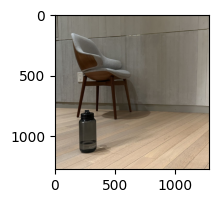


Performing Detection Task without summary data... 

Model Output:
 The center position of bottle is 31 % from the left and 75 % from the top of the image. 

Actual Info:
 The bottle is 22.4609375% from the left of the image, 
 and 70.703125 % from the top of the image


Performing Detection Task with summary data... 

Input summary data: Given the image is (512px with 512px). The center position of bottle is 115 pixels from the left of the image and 362 pixels from the top of the image . The distance from the cameraman is 1.1415831 meters.

Model Output:
 The image is 512 pixels wide and 512 pixels tall. The center position of the bottle is 115 pixels from the left of the image. This means that the bottle is 115 / 512 = 0.2246 * 100 = 22.46% from the left of the image.

The center position of the bottle is 362 pixels from the top of the image. This means that the bottle is 362 / 512 = 0.707 * 100 = 70.7% from the top of the image.

The center position of the bottle is 22.46% from the 

In [ ]:
summary_data = "MLObject(id: 5, center: IntPoint(x: 115, y: 362), depth: 1.1415831, size: 4272, relevanceScore: 0.71439004)"
detection_task(BOTTLE_CHAIR, "bottle", summary_data)
summary_data = "MLObject(id: 5, center: IntPoint(x: 97, y: 384), depth: 1.091873, size: 5824, relevanceScore: 0.64765877)"
detection_task(BOTTLE_CHAIR_TABLE, "bottle", summary_data)

### Depth Map

array([[[232, 234, 233],
        [232, 234, 233],
        [232, 234, 233],
        ...,
        [167, 166, 146],
        [167, 166, 146],
        [168, 167, 147]],

       [[232, 234, 233],
        [233, 235, 234],
        [233, 235, 234],
        ...,
        [167, 166, 146],
        [167, 166, 146],
        [168, 167, 147]],

       [[233, 235, 232],
        [233, 235, 232],
        [234, 236, 233],
        ...,
        [167, 166, 146],
        [167, 166, 146],
        [168, 167, 147]],

       ...,

       [[ 91,  71,  47],
        [ 89,  69,  44],
        [ 88,  68,  44],
        ...,
        [160, 175, 194],
        [159, 174, 193],
        [159, 176, 192]],

       [[ 90,  70,  46],
        [ 89,  69,  45],
        [ 87,  67,  43],
        ...,
        [160, 175, 194],
        [160, 175, 194],
        [159, 176, 192]],

       [[ 89,  67,  46],
        [ 89,  67,  46],
        [ 88,  66,  45],
        ...,
        [162, 177, 196],
        [159, 174, 193],
        [160, 175, 194]]], dtype=uint8)
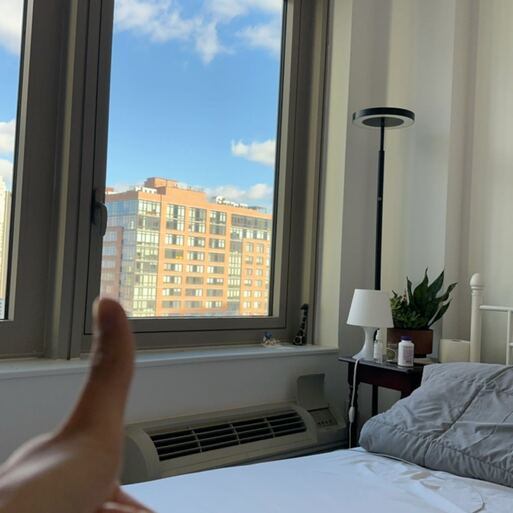

In [ ]:
np.array(Image.open(INPUT_PERSON_PLANT))

In [ ]:
np.array(Image.open(DEPTH_MAP_PERSON_PLANT)).max()

255

#### Inference Task

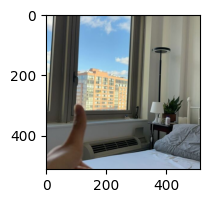


Performing Detection Task without summary data... 

Model Output:
 I am sorry, I cannot see or analyze any image. I am a text-based chat assistant and thus I cannot process any image. 

Actual Info:
 The plant is 2.91 m from the cameraman, 
 400px from the left of the image, 
 and 370 px from the top of the image


Performing Detection Task with summary data... 

1. With no target summary data 

Model Output:
 The plant's distance to the cameraman is : 2.45 m
 The center position of plant is 750 px from the left and 
 650 px from the top of the image.

Here is how we obtain the results: 
The person is 100 pixels from the left of the image and 400 pixels from the top of the image. The distance of the person to the camera is 1.31 m.
 The plant is 750 pixels from the left of the image and 650 pixels from the top of the image. We assume a linear relationship between the distance and the pixel position. The plant is 650 pixels from the top of the image, so we assume it is 1.31 * 650 / 400 

In [ ]:
BASE_PATH = "/content/drive/MyDrive/DS-GA-1006-Capstone/"
DEPTH_MAP_PERSON_PLANT = os.path.join(BASE_PATH, "sample_depth_image.jpeg")
INPUT_PERSON_PLANT = os.path.join(BASE_PATH, "sample_input_image.jpeg")

# person
summary_data_src = "MLObject(id: 15, center: IntPoint(x: 100, y: 400), depth: 1.31, size: 8013, relevanceScore: 0.69)"

# plant
summary_data_target = "MLObject(id: 16, center: IntPoint(x: 400, y: 370), depth: 2.91, size: 1530, relevanceScore: 0.73)"
inference_task_depth_map(Image.open(INPUT_PERSON_PLANT), Image.open(DEPTH_MAP_PERSON_PLANT), "person", "plant", summary_data_src, summary_data_target, accurate=True, show_prompt=False)

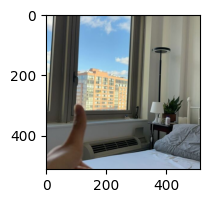


Performing Detection Task without summary data... 

Model Output:
 The plant's distance to the cameraman is : 2.24 m
 The center position of plant is 750 px from the left and 
 630 px from the top of the image.


I was able to extract the position and the distance to the camera of the plant by analyzing the depth map.
The plant is located at 750 px from the left and 630 px from the top.
The brightness of the plant pixels in the depth map is 137/255, and the brightness of the person's hand pixels is 255/255.
Assuming a linear relationship between brightness and distance, the distance of the plant to the camera is calculated as (255/137) times the distance of the person's hand to the camera.
Since the person's hand is touching the camera, the plant is 2.24 m away from the camera.
Actual Info:
 The plant is 2.91 m from the cameraman, 
 400px from the left of the image, 
 and 370 px from the top of the image


Performing Detection Task with summary data... 

1. With no target summary data

In [ ]:
BASE_PATH = "/content/drive/MyDrive/DS-GA-1006-Capstone/"
DEPTH_MAP_PERSON_PLANT = os.path.join(BASE_PATH, "sample_depth_image.jpeg")
INPUT_PERSON_PLANT = os.path.join(BASE_PATH, "sample_input_image.jpeg")

# person
summary_data_src = "MLObject(id: 15, center: IntPoint(x: 100, y: 400), depth: 1.31, size: 8013, relevanceScore: 0.69)"

# plant
summary_data_target = "MLObject(id: 16, center: IntPoint(x: 400, y:370), depth: 2.91, size: 1530, relevanceScore: 0.73)"
inference_task_depth_map(Image.open(INPUT_PERSON_PLANT), Image.open(DEPTH_MAP_PERSON_PLANT), "person", "plant", summary_data_src, summary_data_target, accurate=True, show_prompt=False)

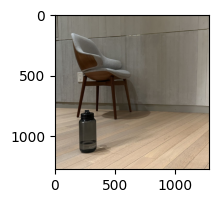


Performing Detection Task without summary data... 

Model Output:
 The chair's distance to the cameraman is : 2.8 m
The center position of chair is 38 % from the left and 56 % from the top of the image.
Actual Info:
 The chair is 2.0098135 m from the cameraman, 
 29.296875% from the left of the image, 
 and 32.8125 % from the top of the image


Performing Detection Task with summary data... 

1. With no target information 

Input summary data:
 Given the image is (512px with 512px). The center position of bottle is 115 pixels from the left of the image and 362 pixels from the top of the image, 
and the distance from the cameraman is 1.1415831 meters. 




Model Output:
 The chair's distance to the cameraman is : 1.617 m
 The center position of chair is 58 % from the left and 
 52 % from the top of the image.
Actual Info:
 The chair is 2.0098135 m from the cameraman, 
 29.296875% from the left of the image, 
 and 32.8125 % from the top of the image


2. With target coordinate 

Input s

In [ ]:
summary_data_src = "MLObject(id: 5, center: IntPoint(x: 115, y: 362), depth: 1.1415831, size: 4272, relevanceScore: 0.71439004)"
summary_data_target = "MLObject(id: 9, center: IntPoint(x: 150, y: 168), depth: 2.0098135, size: 18928, relevanceScore: 0.8094042)"
inference_task(BOTTLE_CHAIR, "bottle", "chair", summary_data_src, summary_data_target)

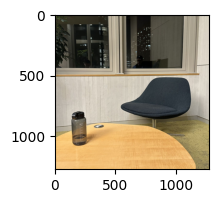


Performing Detection Task without summary data... 

Model Output:
 The chair's distance to the cameraman is :  2.5 m
 The center position of chair is 57 % from the left and 57 % from the top of the image.
Actual Info:
 The chair is 1.8140188 m from the cameraman, 
 76.953125% from the left of the image, 
 and 55.2734375 % from the top of the image


Performing Detection Task with summary data... 

1. With no target information 

Input summary data:
 Given the image is (512px with 512px). The center position of bottle is 97 pixels from the left of the image and 384 pixels from the top of the image, 
and the distance from the cameraman is 1.091873 meters. 




Model Output:
 The chair's distance to the cameraman is : 1.86 m
 The center position of chair is 54 % from the left and 53 % from the top of the image.
Actual Info:
 The chair is 1.8140188 m from the cameraman, 
 76.953125% from the left of the image, 
 and 55.2734375 % from the top of the image


2. With target coordinate 

Inpu

In [ ]:
summary_data_src = "MLObject(id: 5, center: IntPoint(x: 97, y: 384), depth: 1.091873, size: 5824, relevanceScore: 0.64765877)"
summary_data_target = "MLObject(id: 9, center: IntPoint(x: 394, y: 283), depth: 1.8140188, size: 29808, relevanceScore: 0.8167724)"
inference_task(BOTTLE_CHAIR_TABLE, "bottle", "chair", summary_data_src, summary_data_target)

# 3 Compare with different inputs

In [ ]:
!pip install nltk
!pip install rouge-score
!pip install bert-score


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score

## Evaluation Metrics

1. **ROUGE**: Surface-level metric, evaluating text summarization. It measures the overlap between n-grams or the longest common subsequence (LCS) between the generated text and reference texts.
2. **BertScore**: Semantic-level metrics assess the semantic coherence and relevance of the model's outputs in comparison to the ground truths.
3. **BLEU**: Focuses on precision of n-gram overlap. Best suited for tasks requiring word-level matching like machine translation.

In [ ]:
def rouge(candidate, reference):
  """
  Calculate ROUGE score between reference and candidate text.

  :param reference: The ground truth text.
  :param candidate: The generated text.
  :return: ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)
  """
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = scorer.score(reference, candidate)
  return scores


def bertScore(candidate, reference):
  """
  Calculate BERTScore between reference and candidate text.

  :param reference: The ground truth text (list of texts).
  :param candidate: The generated text (list of texts).
  :return: BERTScore (Precision, Recall, F1)
  """
  P, R, F1 = score([candidate], [reference], lang="en", verbose=True)
  return {'precision': P.mean().item(), 'recall': R.mean().item(), 'f1': F1.mean().item()}


def bleu(candidate, reference):
  """
  Calculate the BLEU score between a reference and a candidate text.

  :param reference: The ground truth text (as a list of words).
  :param candidate: The generated text (as a list of words).
  :return: BLEU score
  """
  reference = [reference.split()]  # NLTK expects list of list of words
  candidate = candidate.split()
  score = sentence_bleu(reference, candidate)
  return score

## 3.0 Evaluation Dataset


In [ ]:
# One-time execution
%cd /content/drive/MyDrive/VIALM_datasets/
!git clone https://github.com/YiyiyiZhao/VIALM.git

## 3.1 Original Image + System Prompt

## 3.2 Original Image + System Prompt + User Prompt

## 3.3 Original Image + System Prompt + User Prompt + Depth Map

# 4 Compare between models

## Llava-1.5

## Llava-oneVision

## Google Gemini-pro